# Stock Prediction
### Ignacio Fernández Adrados

---

In [1]:
import pandas as pd # type: ignore

STOCK = 'AMZN'
YEAR = '2023'

FILE='Datasets/Stock-'+STOCK+'-'+YEAR+'.csv'
file=pd.read_csv(FILE, sep=',')
file = file.sort_values(by='timestamp', ascending=True)
file.head()

,timestamp,open,high,low,close,volume
16483,2023-01-03 04:00:00,85.01,85.15,84.65,85.15,4608
16482,2023-01-03 04:01:00,85.11,85.11,85.11,85.11,301
16481,2023-01-03 04:02:00,85.19,85.27,85.16,85.27,2806
16480,2023-01-03 04:03:00,85.22,85.22,85.17,85.17,1223
16479,2023-01-03 04:04:00,85.33,85.34,85.28,85.33,2441


In [60]:
from datetime import datetime

N='15min'     #Minutos agrupados
DATEFILTER='' #Filtro de fecha

df = file[file['timestamp'].str.startswith(DATEFILTER)]
df=pd.DataFrame(df)
df['timestamp'] = pd.to_datetime(df['timestamp'])

dfgroup = pd.DataFrame(df.groupby(pd.Grouper(key='timestamp', freq=N)).first()['open'])
dfgroup = dfgroup.join(df.groupby(pd.Grouper(key='timestamp', freq=N)).last()['close'])
dfgroup = dfgroup.join(df.groupby(pd.Grouper(key='timestamp', freq=N)).min()['low'])
dfgroup = dfgroup.join(df.groupby(pd.Grouper(key='timestamp', freq=N)).max()['high'])
dfgroup = dfgroup.join(df.groupby(pd.Grouper(key='timestamp', freq=N, offset='60min')).sum()['volume'])
dfgroup =pd.DataFrame(pd.to_datetime(dfgroup.index[1:])).join(dfgroup[:-1].reset_index(drop=True))
dfgroup


,timestamp,open,close,low,high,volume
0,2023-01-03 04:15:00,85.010,85.2900,84.65,85.34,28109
1,2023-01-03 04:30:00,85.290,85.4000,85.22,85.50,12875
2,2023-01-03 04:45:00,85.370,85.6400,85.37,85.64,7315
3,2023-01-03 05:00:00,85.630,85.5900,85.51,85.66,3846
4,2023-01-03 05:15:00,85.590,85.4800,85.48,85.64,4798
...,...,...,...,...,...,...
34618,2023-12-29 18:45:00,151.800,151.7982,151.75,151.80,2187
34619,2023-12-29 19:00:00,151.800,151.7700,151.75,151.80,2712
34620,2023-12-29 19:15:00,151.770,151.7500,151.70,151.77,3292
34621,2023-12-29 19:30:00,151.735,151.7700,151.70,151.77,2361


In [9]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

dfgroup['EMA7']= dfgroup['close'].ewm(span=7, adjust=False).mean()
dfgroup['MACD']= dfgroup['close'].ewm(span=12, adjust=False).mean()- dfgroup['close'].ewm(span=26, adjust=False).mean()
dfgroup['SignalMACD'] = dfgroup['MACD'].ewm(span=9, adjust=False).mean()
dfgroup['RSI'] = get_rsi(dfgroup['close'], 14)
dfgroup = dfgroup.dropna()
dfgroup = dfgroup.reset_index(drop=True)
dfgroup.head()

,open,close,low,high,volume,EMA7,MACD,SignalMACD,RSI
0,103.025,102.93,102.6200,103.2100,6456328,102.566273,-0.023893,-0.021614,61.866979
1,101.960,103.02,101.5558,103.3484,13667618,102.679705,0.013508,-0.014590,64.174249
2,100.650,101.96,100.4400,102.2000,4222195,102.499779,-0.041901,-0.020052,36.309124
3,99.920,100.80,99.7000,100.8000,179412,102.074834,-0.177371,-0.051516,24.018332
4,99.800,99.90,99.4200,99.9800,56097,101.531126,-0.353282,-0.111869,18.722852


In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Normalise data into (0,1) range
normData=dfgroup
scaler = MinMaxScaler(feature_range=(0, 1))
#normData[['open']] = scaler.fit_transform(normData[['open']])
normData[['open','close','low','high','volume','EMA7','MACD','SignalMACD','RSI']] = scaler.fit_transform(normData[['open','close','low','high','volume','EMA7','MACD','SignalMACD','RSI']])
normData.head()

(3644, 9)

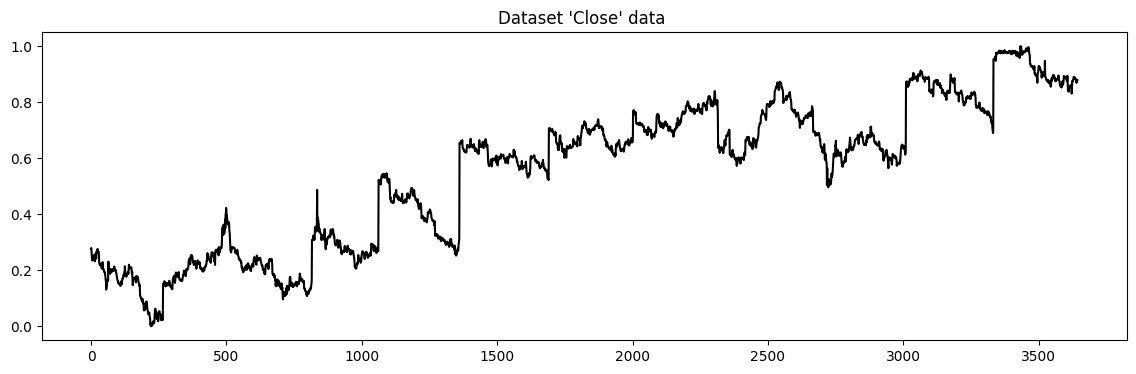

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.title("Dataset 'Close' data ")
plt.plot(normData['close'],color='black')
#plt.scatter(normData.index, np.where(normData['buysell'] == -1,normData['close'], None), color="red", marker="v")
#plt.scatter(normData.index, np.where(normData['buysell'] ==  1,normData['close'], None), color="blue", marker="^")
plt.show()

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing.

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [18]:
S=0.7
step = 5

split = int(len(normData) * S)
#values = normData.values
#print(values)
train = normData[:split]#.drop(['buysell'],axis=1)
test = pd.concat([train.tail(step),normData[split:]]).reset_index(drop=True)

print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2550, 9)
Test data length: (1099, 9)


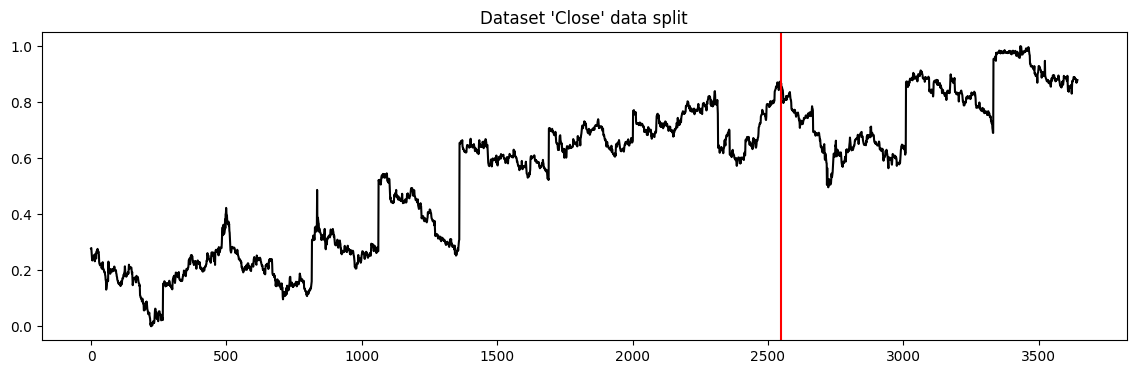

In [19]:
plt.figure(figsize=(14,4))
plt.title("Dataset 'Close' data split")
plt.plot(normData.index.values,normData['close'],c='black')
plt.axvline(normData.index[split], c="r")
#plt.scatter(normData.index, np.where(normData['buysell'] == -1,normData['close'], None), color="red",  marker="v")
#plt.scatter(normData.index, np.where(normData['buysell'] ==  1,normData['close'], None), color="blue", marker="^")
plt.show()


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [21]:
import numpy as np

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        #print(i, d, data[i:d)
        X.append(data[i:d])
        Y.append(data[d,1])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train.to_numpy(),step)
testX,testY =convertToMatrix(test.to_numpy(),step)
#print(trainY)
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)


Training data shape: (2545, 5, 9) ,  (2545,)
Test data shape: (1094, 5, 9) ,  (1094,)


### Keras model with `SimpleRNN` layer

- 256 neurons in the RNN layer
- 32 denurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [24]:
from keras import Sequential
from keras.layers import Dense, SimpleRNN, Input, LSTM, Dropout # type: ignore

UNITS = 500 #num_units: Number of units of a the simple RNN layer
DENSEUNITS = 32 #Number of neurons in the dense layer followed by the RNN layer
LR = 0.001 #Learning rate (uses RMSprop optimizer)

model = Sequential()
model.add(Input((step, trainX.shape[2])))
model.add(LSTM(units=UNITS, activation="tanh",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=UNITS//2, activation="tanh"))
model.add(Dropout(0.2))
#model.add(SimpleRNN(units=UNITS//3, activation="relu"))
model.add(Dense(DENSEUNITS, activation="tanh"))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer=RMSprop(LR),metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 500)         │     1,020,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250)            │       751,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,779,065 (6.79 MB)

 Trainable params: 1,779,065 (6.79 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the model

In [26]:
from keras.callbacks import Callback # type: ignore

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        #if (epoch+1) % 10 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

batch_size=64
num_epochs = 5

model.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

Epoch number 1 done
Epoch number 2 done
Epoch number 3 done
Epoch number 4 done
Epoch number 5 done


### Plot loss

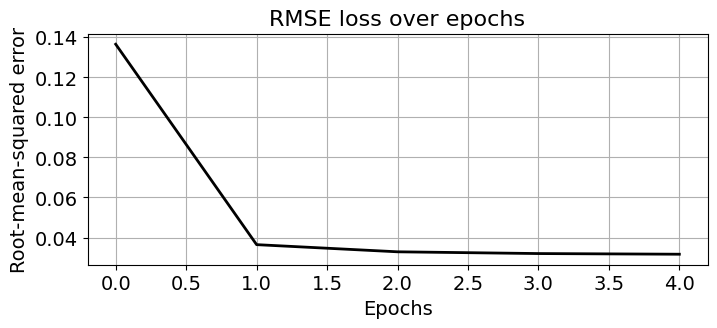

In [27]:
plt.figure(figsize=(8,3))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data.

In [28]:
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
print(trainPredict.shape)
print(testPredict.shape)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(2545, 1)
(1094, 1)


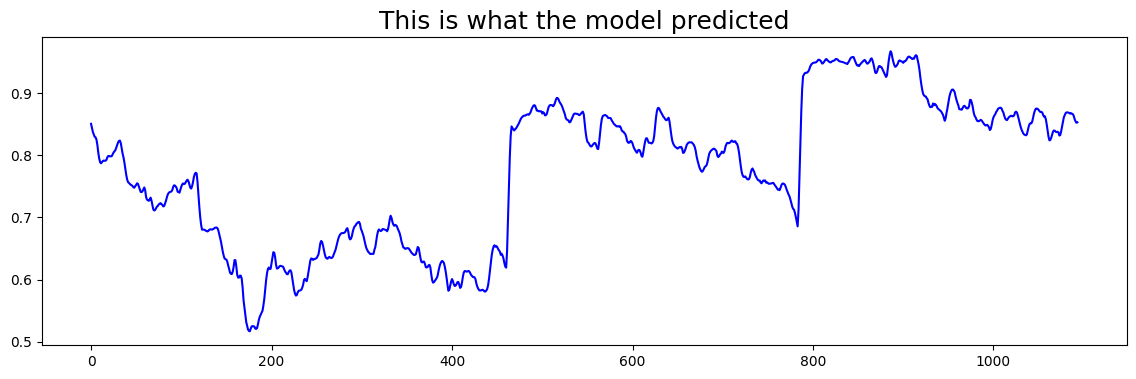

In [29]:
plt.figure(figsize=(14,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,color='blue')
plt.show()

### Comparing it with the ground truth (test set)

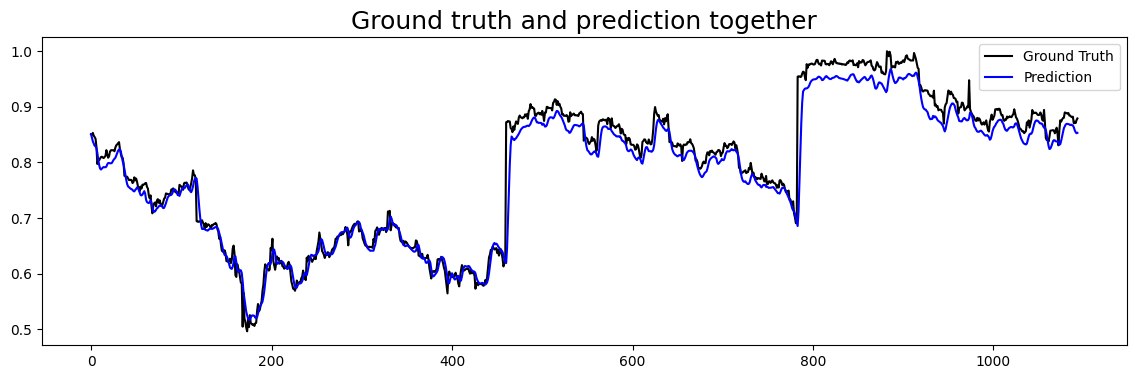

In [30]:
OFFSET=0

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black', label='Ground Truth')
plt.plot(testPredict[OFFSET:],color='blue', label='Prediction')
plt.legend()
plt.show()

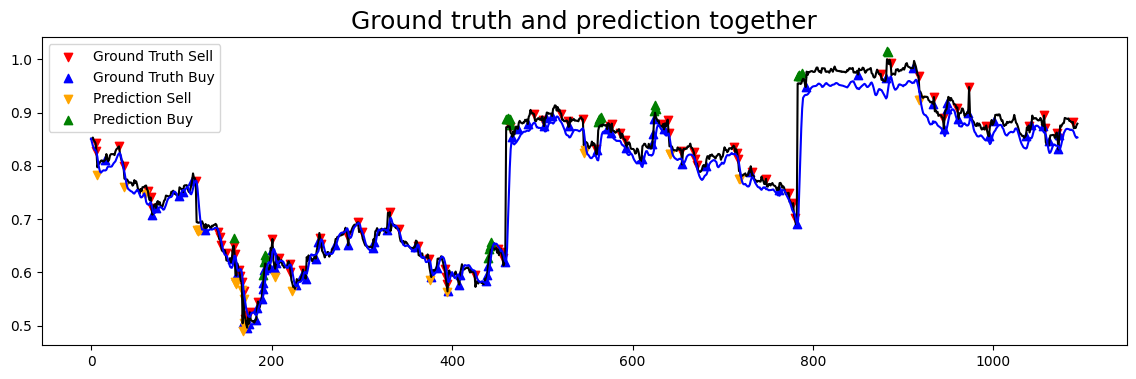

In [31]:
PROFIT=0.01
OFFSET=0

decision=test['close'].iloc[step:]
decision = decision.diff()
decision = decision.dropna()
decision = np.where(abs(decision)<PROFIT,0,np.sign(decision).astype('int'))
decision = pd.DataFrame(data={'buysell':decision})#.drop(0).reset_index(drop=True)

predictedDecision = pd.DataFrame(data={'buysellPredicted':testPredict[:,0]})
predictedDecision = predictedDecision.diff()
predictedDecision = predictedDecision.dropna()#.reset_index(drop=True)
predictedDecision = np.where(abs(predictedDecision)<PROFIT,0,np.sign(predictedDecision).astype('int'))
predictedDecision = pd.DataFrame(data={'buysellPredicted':predictedDecision[:,0]})

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black')
plt.plot(testPredict[OFFSET:],color='blue')

x = decision.iloc[OFFSET:].reset_index(drop=True).index
y = normData['close'].iloc[len(normData)-len(predictedDecision.index)-1+OFFSET:-1].reset_index(drop=True)

plt.scatter(x, np.where(decision['buysell'].iloc[OFFSET:] == -1,y, None), color="red",  marker="v", label='Ground Truth Sell')
plt.scatter(x, np.where(decision['buysell'].iloc[OFFSET:] ==  1,y, None), color="blue", marker="^", label='Ground Truth Buy')

plt.scatter(x, np.where(predictedDecision['buysellPredicted'].iloc[OFFSET:] == -1,y-0.015, None), color="orange",  marker="v", label='Prediction Sell')
plt.scatter(x, np.where(predictedDecision['buysellPredicted'].iloc[OFFSET:] ==  1,y+0.015, None), color="green",  marker="^", label='Prediction Buy')
plt.legend()
plt.show()

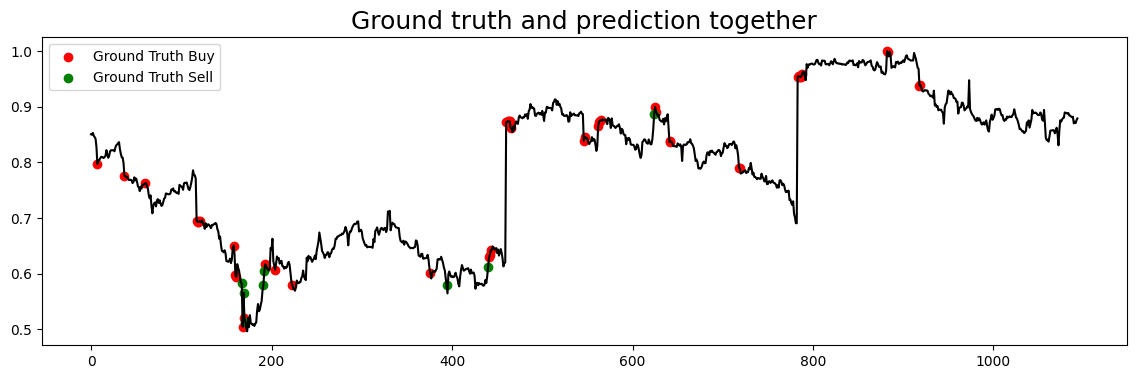

In [32]:
OFFSET=0

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black')
#plt.plot(testPredict[OFFSET:],color='blue')

x = decision.iloc[OFFSET:].reset_index(drop=True).index
y = normData['close'].iloc[len(normData)-len(predictedDecision.index)-1+OFFSET:-1].reset_index(drop=True)

plt.scatter(x, np.where((decision['buysell'].iloc[OFFSET:] !=  predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (predictedDecision['buysellPredicted'].iloc[OFFSET:] != 0),y, None), color="red", label='Ground Truth Buy')
plt.scatter(x, np.where((decision['buysell'].iloc[OFFSET:] == predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (decision['buysell'].iloc[OFFSET:] != 0),y, None), color="green",  label='Ground Truth Sell')

plt.legend()
plt.show()

In [33]:
print("Predicciones no coincidentes con el conjunto de pruebas: ", np.count_nonzero(np.where((decision['buysell'].iloc[OFFSET:] !=  predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (predictedDecision['buysellPredicted'].iloc[OFFSET:] != 0),y, None)))
print("Predicciones coincidentes con el conjunto de pruebas: ", np.count_nonzero(np.where((decision['buysell'].iloc[OFFSET:] == predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (decision['buysell'].iloc[OFFSET:] != 0),y, None)))

Predicciones no coincidentes con el conjunto de pruebas:  49
Predicciones coincidentes con el conjunto de pruebas:  8
